In [1]:
from graphviz import Digraph
from IPython.display import Image, display
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import scipy.stats as stats
from scipy.stats import nct, t


In [2]:
df = pd.read_csv('data/cohorte_endo_processed.csv')

In [3]:

def probability_significant_difference(n_positives, n_negatives, alpha=0.05, effect_size=0.5):
    """
    Calculate the statistical power of a two-sample t-test (Welch's t-test) or the false positive rate.

    Parameters:
        n_positives (int): Number of positive cases (group 1).
        n_negatives (int): Number of negative cases (group 2).
        alpha (float): Significance level for the test (default is 0.05).
        effect_size (float): Effect size (Cohen's d), default is 0.5 (medium effect size).

    Returns:
        float: Estimated power (or probability of rejecting the null hypothesis).
    """
    if n_positives <= 0 or n_negatives <= 0:
        return None  # Insufficient data

    # Degrees of freedom for Welch's t-test
    df = ((n_positives - 1) + (n_negatives - 1))

    # Critical t-value for the given alpha
    t_critical = t.ppf(1 - alpha / 2, df)

    # Non-centrality parameter (NCP)
    # NCP is effect_size * sqrt((n1 * n2) / (n1 + n2)), where n1 and n2 are group sizes
    ncp = effect_size * np.sqrt((n_positives * n_negatives) / (n_positives + n_negatives))

    # Compute power using the non-central t-distribution
    power = nct.cdf(-t_critical, df, ncp) + (1 - nct.cdf(t_critical, df, ncp))

    return power


In [4]:
def calculate_power(n_positives, n_negatives, effect_size, alpha=0.05, sd=1):
    """
    Calculate the statistical power of a two-sample t-test.
    
    Parameters:
        n_positives (int): Number of observations in the first group.
        n_negatives (int): Number of observations in the second group.
        effect_size (float): The true difference in means between the groups.
        alpha (float): Significance level for the test (default is 0.05).
        sd (float): Standard deviation of the data (assuming equal SD for both groups).
    
    Returns:
        float: Statistical power of the test.
    """
    # Pooled standard deviation
    s_pooled = sd * ((1 / n_positives) + (1 / n_negatives)) ** 0.5
    
    # Degrees of freedom
    df = n_positives + n_negatives - 2
    
    # Non-centrality parameter
    delta = effect_size / s_pooled
    
    # Critical t-value for two-tailed test
    t_critical = stats.t.ppf(1 - alpha / 2, df)
    
    # Calculate power
    power = stats.nct.sf(t_critical, df, delta) + stats.nct.cdf(-t_critical, df, delta)
    
    return power

In [5]:

def calculate_mde(n_positives, n_negatives, alpha, power=0.8):
    """
    Calculate the minimum detectable effect size given sample sizes, alpha, and power.

    Parameters:
        n_positives (int): Number of positive cases.
        n_negatives (int): Number of negative cases.
        alpha (float): Significance level.
        power (float): Desired power level.

    Returns:
        float: Minimum detectable effect size.
    """
    from statsmodels.stats.power import TTestIndPower
    power_analysis = TTestIndPower()

    # Compute the ratio of negatives to positives
    ratio = n_negatives / n_positives

    # Calculate minimum detectable effect size
    mde = power_analysis.solve_power(
        effect_size=None,
        nobs1=n_positives,
        alpha=alpha,
        power=power,
        ratio=ratio,
        alternative="two-sided",
    )
    return mde


In [6]:
    def balance_by_subtypes(df, base_condition, subtypes):
        """
        Balance the data based on the minimum count for each subtype.

        Parameters:
            df (pd.DataFrame): Input DataFrame to balance.
            base_condition (str): Base condition to filter the DataFrame (e.g., endometriosis condition).
            subtypes (list): List of subtype columns to balance.

        Returns:
            int: Minimum count of rows matching the balanced condition.
        """
        counts = []
        for subtype in subtypes:
            condition = f"{base_condition} & {subtype} == 1"
            count = df.query(condition).shape[0]
            counts.append(count)
        return min(counts)

In [7]:
def compute_probabilities_with_conditions(
    df,
    conditions,
    alpha=0.05,
    effect_size=0.5,
):
    """
    Compute probabilities, MDE, and MDFC for specified conditions in a DataFrame with optional balancing.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        conditions (list of dict): List of dictionaries specifying conditions, negatives, and balance.
                                   Example:
                                   [
                                       {"positive": "endometriosis == 1", 
                                        "negative": "endometriosis == 0",
                                        "balance": [["phase"], ["subtype_myoma", "subtype_adenomyosis"]]},
                                       {"positive": "endometriosis == 1 & hormone_treatment == 1", 
                                        "negative": "endometriosis == 0 & hormone_treatment == 0",
                                        "balance": [["phase"]]}
                                   ]
        alpha (float): Significance level for the test (default is 0.05).
        effect_size (float): Expected effect size for power calculations (default is 0.5).

    Returns:
        pd.DataFrame: DataFrame with probabilities, MDE, and MDFC for each condition.
    """
    results = []

    

    for cond in conditions:
        positive_condition = cond["positive"]
        negative_condition = cond["negative"]
        balance = cond.get("balance", None)

        n_positives = None
        n_negatives = None

        # Apply balancing if specified
        if balance:
            for subtypes in balance:
                n_positives = balance_by_subtypes(df, positive_condition, subtypes)
        else:
            # Direct counts if no balancing is specified
            n_positives = df.query(positive_condition).shape[0]

        # Direct counts for negatives
        n_negatives = df.query(negative_condition).shape[0]

        if n_positives > 0 and n_negatives > 0:
            # Compute power for the primary alpha
            power = calculate_power(n_positives, n_negatives, effect_size, alpha=alpha)

            # Compute MDE (Minimum Detectable Effect)
            mde = calculate_mde(n_positives, n_negatives, alpha, power=0.8)
        else:
            power = None
            mde = None

        # Store the result
        results.append(
            {
                "positive_condition": positive_condition,
                "negative_condition": negative_condition,
                "balance": balance,
                "n_positives": n_positives,
                "n_negatives": n_negatives,
                "power": round(power, 3) if power is not None else None,
                "mde": round(mde, 3) if mde is not None else None,
            }
        )

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df


In [8]:
df.columns

Index(['center', 'sample_code', 'sample_code_ua', 'collected_at',
       'cervical_cytology', 'uterine_aspirate', 'date_processed',
       'date_collected', 'age', 'phase', 'other_diseases', 'hormone_treatment',
       'hormone_treatment_maybe', 'endometriosis', 'post_surgery', 'suspected',
       'adenomyosis', 'symptom_asymptomatic', 'symptom_pain',
       'symptom_infertility', 'symptom_unknown', 'subtype_normal',
       'subtype_ovarian', 'subtype_deep', 'subtype_extragenital',
       'subtype_focal_adenomyosis', 'subtype_diffuse_adenomyosis',
       'subtype_myoma', 'subtype_adnexal_pathology', 'subtype_polyp',
       'subtype_hydro_hematosalpinx', 'subtype_unknown'],
      dtype='object')

In [9]:
conditions = [
    {"positive":
        'endometriosis == 1', 
     "negative": 
        'endometriosis == 0',
     "balance": 
        [["subtype_ovarian", "subtype_deep"]]
    }, 
    {"positive":
        'endometriosis == 1', 
     "negative": 
        'endometriosis == 0',
    }, 
    {"positive":
        'endometriosis == 1 & suspected == 0', 
     "negative": 
        'endometriosis == 0 & suspected == 0'
    },
    {"positive":
        'endometriosis == 1 & hormone_treatment == 0', 
     "negative": 
        'endometriosis == 0 & hormone_treatment == 0'
    },
    {"positive":
        'endometriosis == 1 & phase == "secretory"', 
     "negative": 
        'endometriosis == 0 & phase == "secretory"'
    },
    {"positive":
        'endometriosis == 1 & suspected == 0 & subtype_ovarian == 1', 
     "negative": 
        'endometriosis == 1 & suspected == 0 & subtype_ovarian != 1'
    },
]

results_df = compute_probabilities_with_conditions(df, conditions, alpha=0.05)


In [10]:
results_df


,positive_condition,negative_condition,balance,n_positives,n_negatives,power,mde
0,endometriosis == 1,endometriosis == 0,"[[subtype_ovarian, subtype_deep]]",128,144,0.984,0.342
1,endometriosis == 1,endometriosis == 0,None,334,144,0.999,0.280
2,endometriosis == 1 & suspected == 0,endometriosis == 0 & suspected == 0,None,316,110,0.995,0.311
3,endometriosis == 1 & hormone_treatment == 0,endometriosis == 0 & hormone_treatment == 0,None,110,90,0.938,0.400
4,"endometriosis == 1 & phase == ""secretory""","endometriosis == 0 & phase == ""secretory""",None,61,37,0.661,0.590
5,endometriosis == 1 & suspected == 0 & subtype_...,endometriosis == 1 & suspected == 0 & subtype_...,None,142,174,0.993,0.318


In [11]:
null_condition = 'endometriosis == 2'
base_condition = 'suspected == 0 & hormone_treatment_maybe == 0 & collected_at == "operating_room" '
endo_condition = base_condition + '& endometriosis == 1 '
not_endo_condition = base_condition + '& endometriosis == 0 '

deep_condition = endo_condition + '& subtype_deep == 1 '
ovarian_condition = endo_condition + '& subtype_ovarian == 1 '
deep_ovarian_condition = endo_condition + '& subtype_deep == 1 & subtype_ovarian == 1 '
adenomyosis_condition = endo_condition + '& (subtype_focal_adenomyosis == 1 | subtype_diffuse_adenomyosis == 1) '

pain_condition = not_endo_condition + '& symptom_pain == 1 '
infertility_condition = not_endo_condition + '& symptom_infertility == 1 '
asymp_condition = not_endo_condition + '& symptom_asymptomatic == 1 '

hormone_treatment_condition = '& hormone_treatment == 1 '
not_hormone_treatment_condition = '& hormone_treatment == 0 '
secretory_condition = not_hormone_treatment_condition + '& phase == "secretory" '
ovulation_condition = not_hormone_treatment_condition + '& phase == "ovulatory" '
proliferative_condition = not_hormone_treatment_condition + '& phase == "proliferative" '

conditions = [
    {
        "positive": base_condition, "negative":null_condition,
    },
    {
        "positive": endo_condition, "negative":not_endo_condition,
    },    
    {
        "positive": deep_condition, "negative":ovarian_condition,
    },
    {
        "positive": deep_ovarian_condition, "negative":adenomyosis_condition,
    },
    {
        "positive": pain_condition, "negative":null_condition,
    },
    {
        "positive": infertility_condition, "negative":null_condition,
    },
    {
        "positive": asymp_condition, "negative":null_condition,
    },
    

]
results_df = compute_probabilities_with_conditions(df, conditions, alpha=0.05)

results_df

,positive_condition,negative_condition,balance,n_positives,n_negatives,power,mde
0,suspected == 0 & hormone_treatment_maybe == 0 ...,endometriosis == 2,None,111,0,NaN,NaN
1,suspected == 0 & hormone_treatment_maybe == 0 ...,suspected == 0 & hormone_treatment_maybe == 0 ...,None,71,39,0.701,0.563
2,suspected == 0 & hormone_treatment_maybe == 0 ...,suspected == 0 & hormone_treatment_maybe == 0 ...,None,38,34,0.551,0.671
3,suspected == 0 & hormone_treatment_maybe == 0 ...,suspected == 0 & hormone_treatment_maybe == 0 ...,None,18,2,0.097,2.208
4,suspected == 0 & hormone_treatment_maybe == 0 ...,endometriosis == 2,None,3,0,NaN,NaN
5,suspected == 0 & hormone_treatment_maybe == 0 ...,endometriosis == 2,None,0,0,NaN,NaN
6,suspected == 0 & hormone_treatment_maybe == 0 ...,endometriosis == 2,None,17,0,NaN,NaN


In [12]:
conditions = [
    { "positive": deep_condition + proliferative_condition, "negative":null_condition, },
    { "positive": ovarian_condition + proliferative_condition, "negative":null_condition, },
    { "positive": deep_ovarian_condition + proliferative_condition, "negative":null_condition, },
    { "positive": adenomyosis_condition + proliferative_condition, "negative":null_condition, },
    
    
]

results_df = compute_probabilities_with_conditions(df, conditions, alpha=0.05)

results_df

,positive_condition,negative_condition,balance,n_positives,n_negatives,power,mde
0,suspected == 0 & hormone_treatment_maybe == 0 ...,endometriosis == 2,None,1,0,None,None
1,suspected == 0 & hormone_treatment_maybe == 0 ...,endometriosis == 2,None,1,0,None,None
2,suspected == 0 & hormone_treatment_maybe == 0 ...,endometriosis == 2,None,1,0,None,None
3,suspected == 0 & hormone_treatment_maybe == 0 ...,endometriosis == 2,None,0,0,None,None


In [13]:
for i in range(10,100):
    print(i, calculate_power(i,i, 0.65), calculate_mde(i,i, 0.05))



10 0.2801816762758324 1.3249473683434811
11 0.3058942756456377 1.2559512279975953
12 0.3312721343714693 1.1968119488839126
13 0.35626541078766305 1.145371133268793
14 0.38082963833867123 1.1000804814910272
15 0.40492569514469745 1.0597982782460225
16 0.4285196304568708 1.0236637414819447
17 0.45158241331732263 0.9910028984885257
18 0.4740896406209734 0.9612962908789003
19 0.49602122648316826 0.9341188690204867
20 0.5173610861696322 0.9091290410935778
21 0.5380968227749826 0.8860495356533035
22 0.5582194217621792 0.8646478038241827
23 0.5777229565534473 0.8447303335706646
24 0.5966043071274064 0.8261283818921582
25 0.6148628927620783 0.8087077779214854
26 0.6325004195139686 0.7923467015280601
27 0.649520642645954 0.7769417387305425
28 0.6659291439537973 0.7624030622083873
29 0.6817331237561782 0.7486521465568191
30 0.6969412071827169 0.7356198334313554
31 0.7115632643028709 0.7232495799669775
32 0.7256102435752794 0.7114799555165038
33 0.7390940180547416 0.7002688580701711
34 0.75202724

In [14]:
calculate_power(129, 70, 0.5, alpha=0.05, sd=1)


np.float64(0.9179918640012014)

In [15]:
calculate_power(129, 38, 0.5, alpha=0.05, sd=1)


np.float64(0.7682747673641033)

In [21]:
calculate_power(n_positives = 60, n_negatives = 60, effect_size = 0.5, alpha = 0.05)

np.float64(0.7752658885222194)

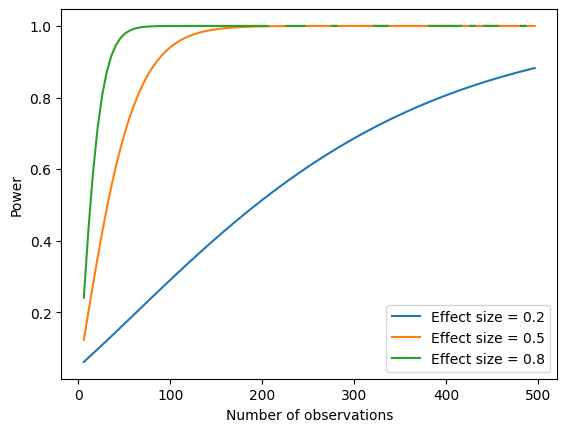

In [32]:
# Plot, for equal and crescent (5 by 5) n of postives and negatives
# for effect sizes 0.2, 0.5, and 0.8
# the statistical power of the test

pows_low = []
pows_med = []
pows_high = []
ns = []
for n in range(1, 501, 5):
    n, pow_low, pow_med, pow_high = n, calculate_power(n, n, 0.2), calculate_power(n, n, 0.5), calculate_power(n, n, 0.8)
    ns.append(n)
    pows_low.append(pow_low)
    pows_med.append(pow_med)
    pows_high.append(pow_high)

#plot
import matplotlib.pyplot as plt
plt.plot(ns, pows_low, label='Effect size = 0.2')
plt.plot(ns, pows_med, label='Effect size = 0.5')
plt.plot(ns, pows_high, label='Effect size = 0.8')
plt.xlabel('Number of observations')
plt.ylabel('Power')
plt.legend()
plt.show()


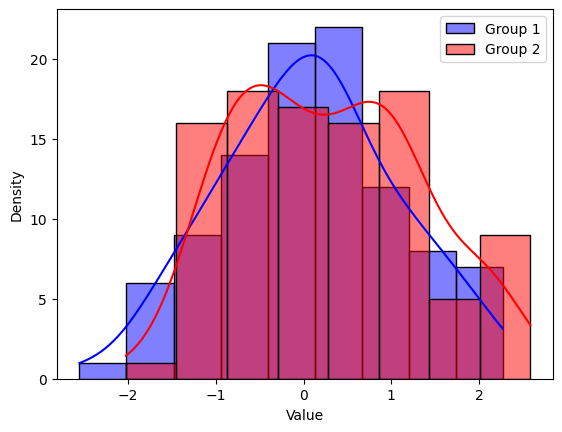

In [33]:
# Draw two gaussians where their effect size is 0.2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seed for reproducibility
np.random.seed(0)

# Generate data
n = 100
effect_size = 0.2
mean1, mean2 = 0, effect_size
sd = 1
data1 = np.random.normal(mean1, sd, n)
data2 = np.random.normal(mean2, sd, n)

# Plot the data
sns.histplot(data1, color='blue', kde=True, label='Group 1')
sns.histplot(data2, color='red', kde=True, label='Group 2')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()